In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
dtype = torch.float
device = torch.device("cuda:4")

from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.sampling import FactorizedFlowPrior
from src.models.flows.analytic_flows.element_wise import AnalyticSigmoid,AnalyticInverseSigmoid

torch.set_default_dtype(torch.float64)

In [2]:
prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(1.2).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)

sampler = FactorizedFlowPrior(d=2,prior_1d=prior)

sig = AnalyticSigmoid(d=2)
asig = AnalyticInverseSigmoid(d=2)

In [3]:
npoints = 100000
points = torch.zeros(npoints,3).to(device).uniform_()
points[:,-1]=0.

In [8]:
def f(x):
    return torch.exp(-10*(x[:,0]-x[:,1])**2)

In [9]:
fs = f(points)

In [10]:
nvps = [
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device),    
]

optim=torch.optim.Adam(sum([list(nvp.parameters()) for nvp in nvps],[]),lr=1.e-4)
Ls = []

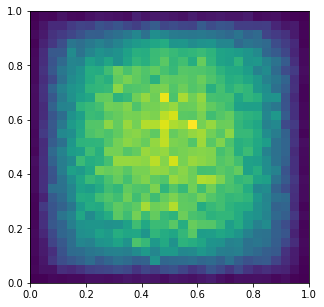

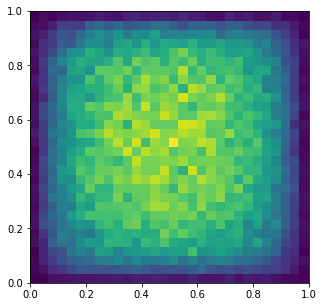

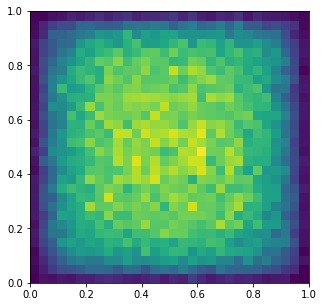

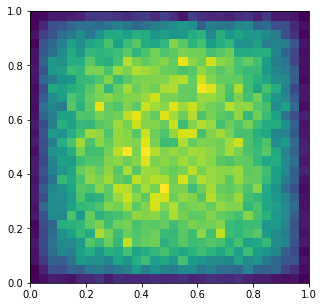

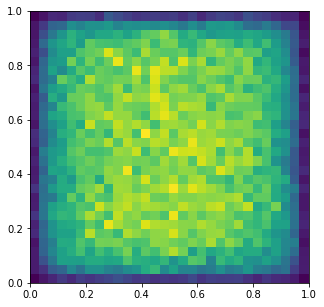

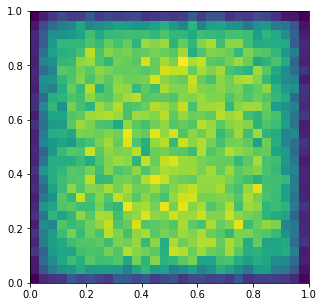

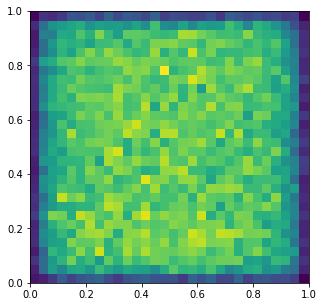

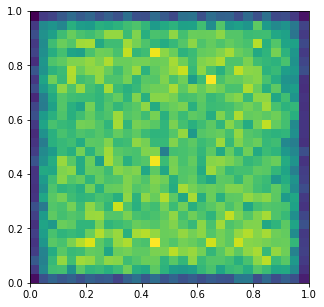

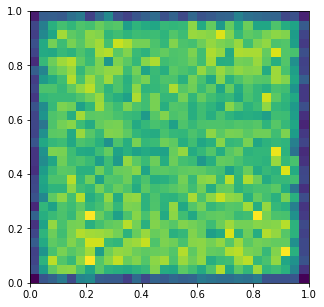

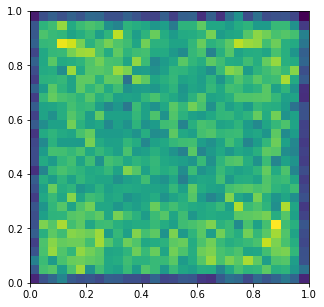

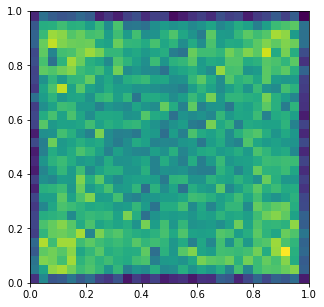

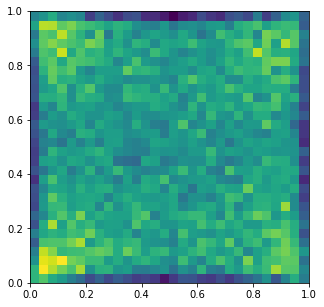

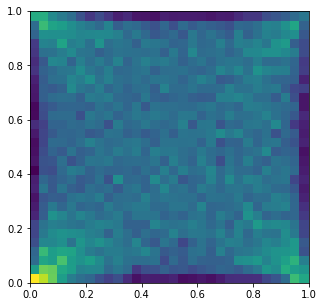

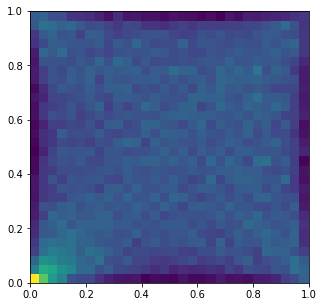

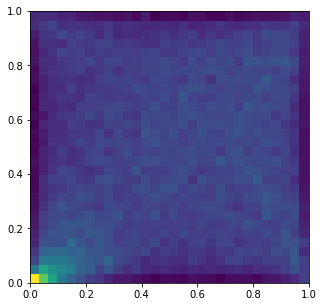

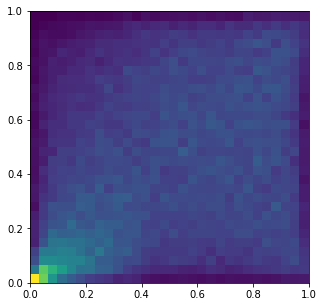

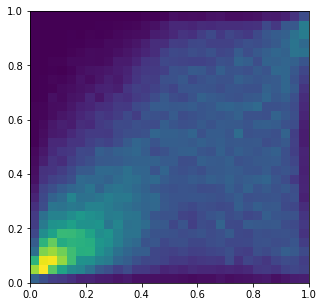

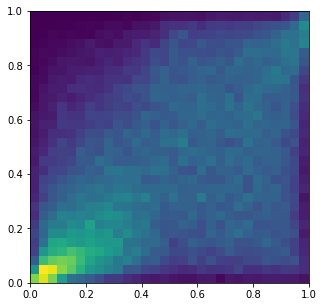

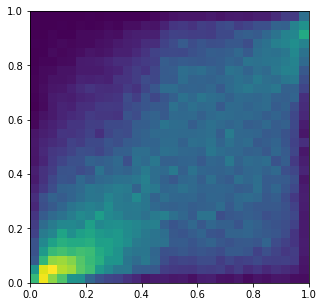

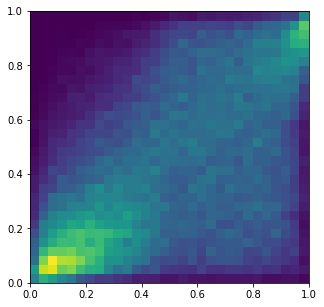

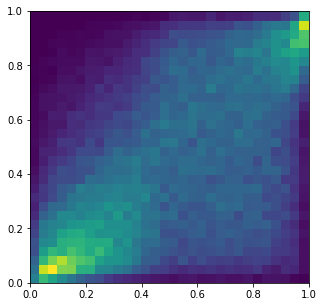

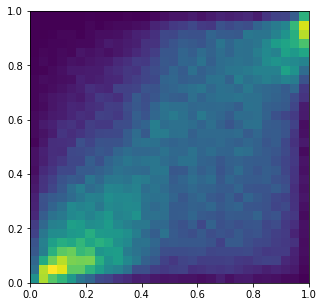

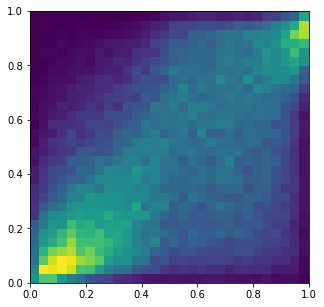

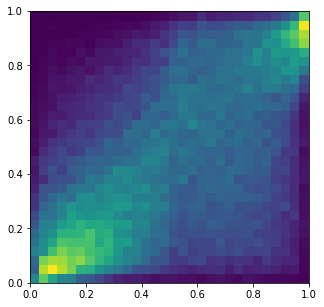

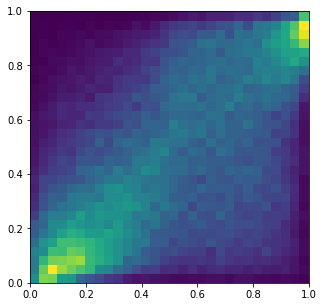

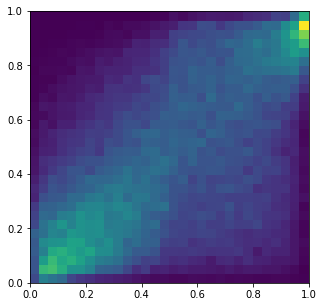

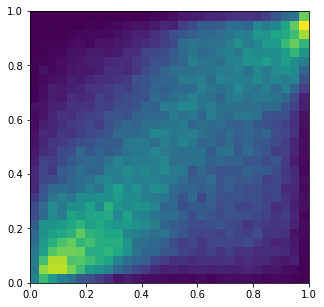

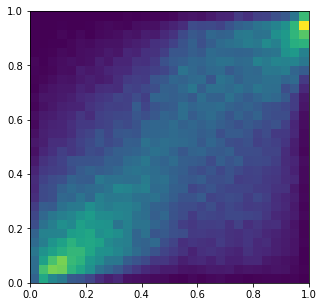

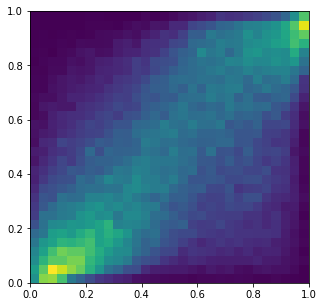

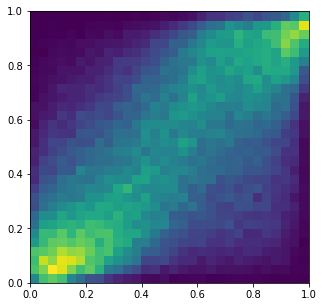

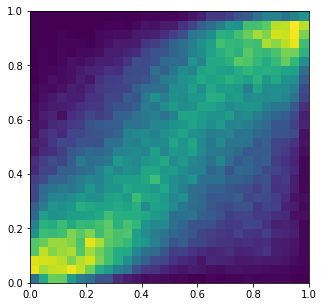

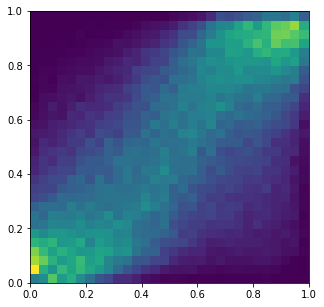

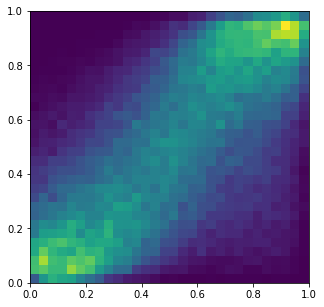

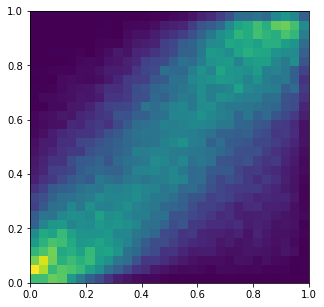

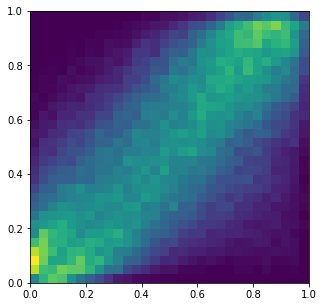

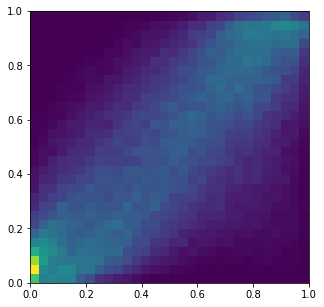

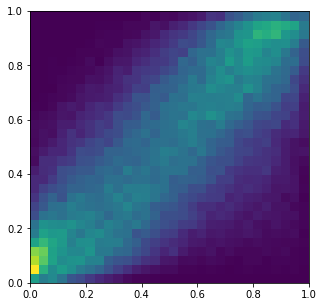

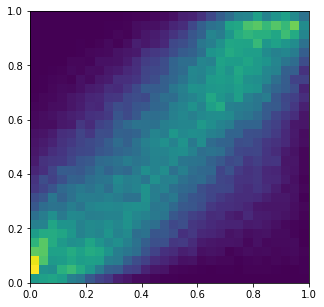

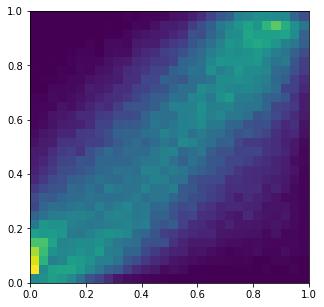

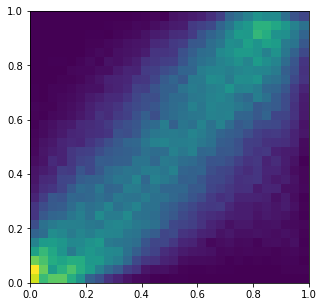

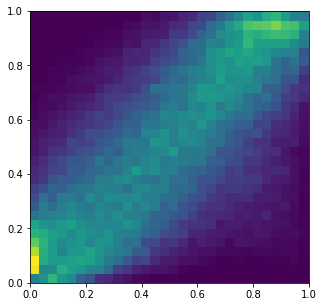

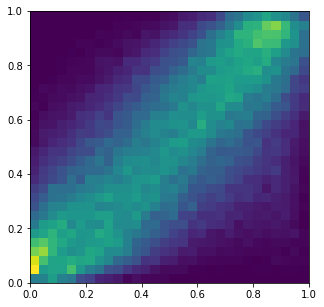

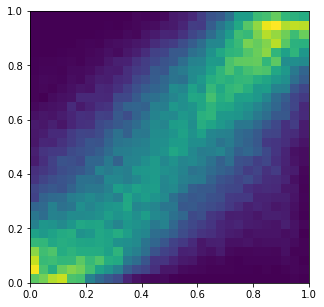

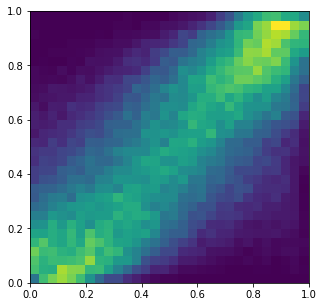

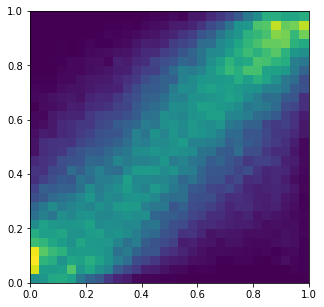

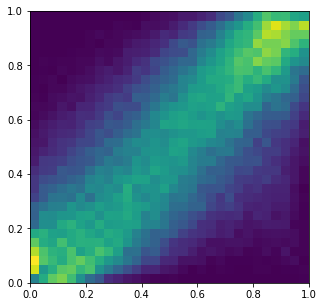

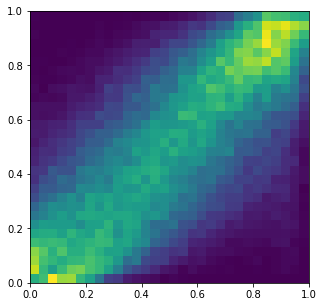

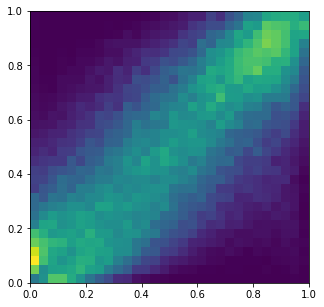

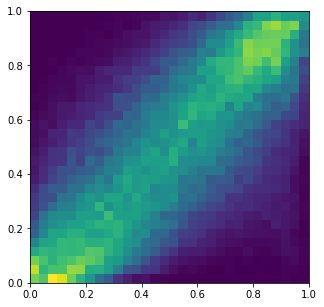

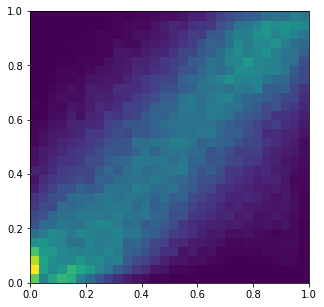

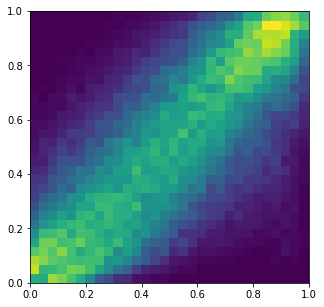

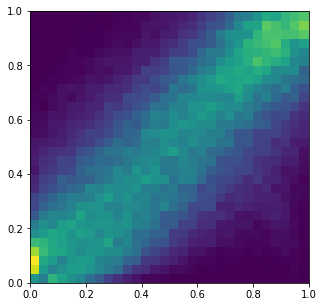

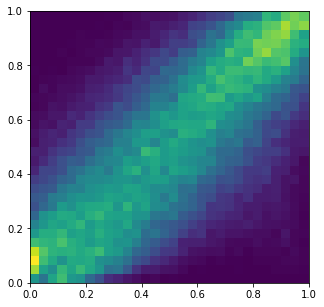

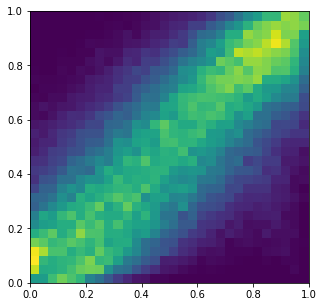

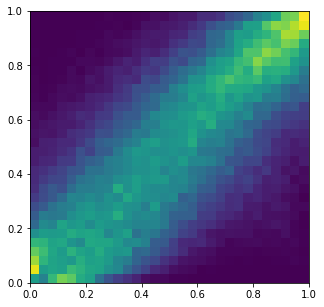

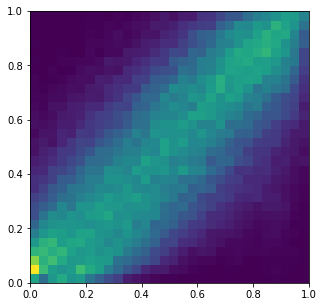

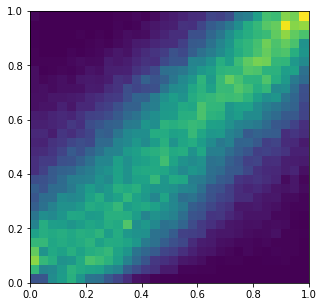

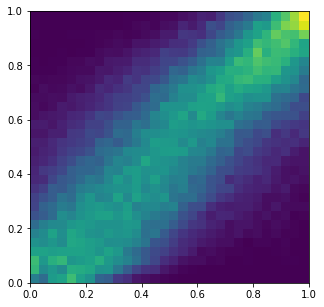

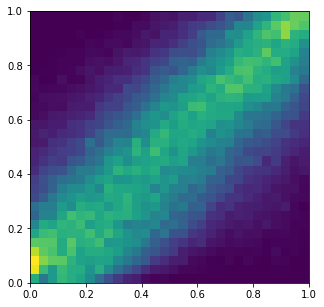

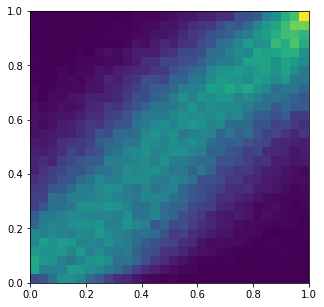

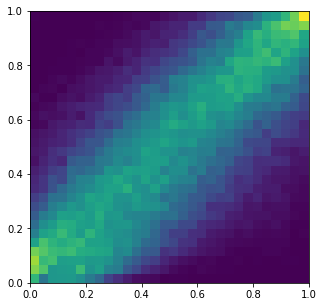

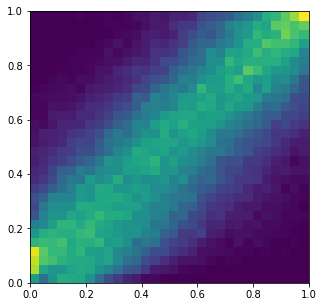

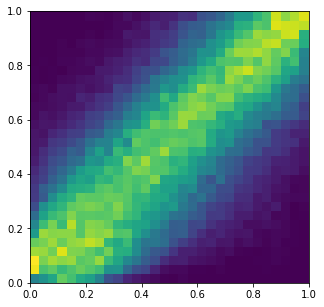

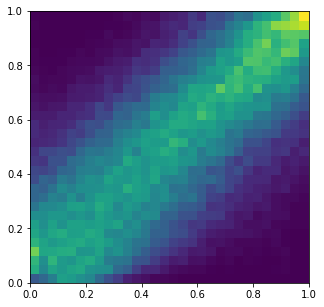

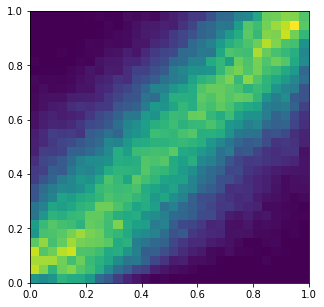

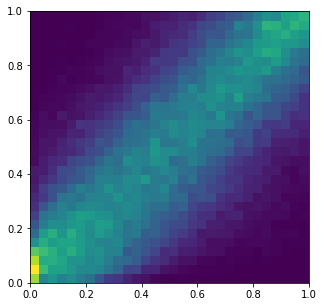

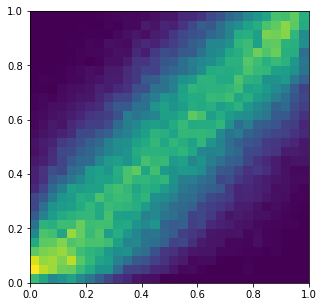

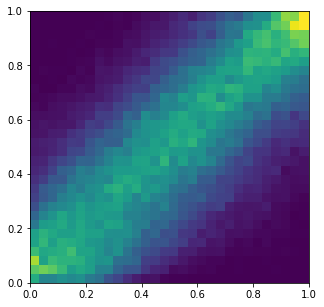

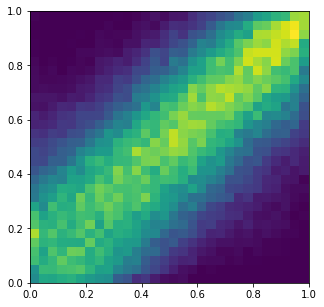

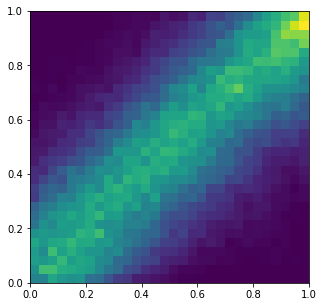

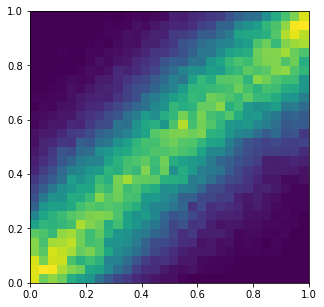

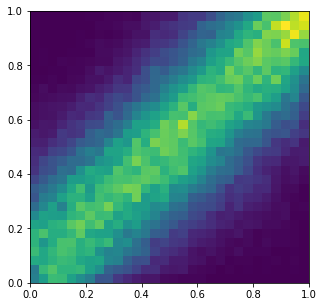

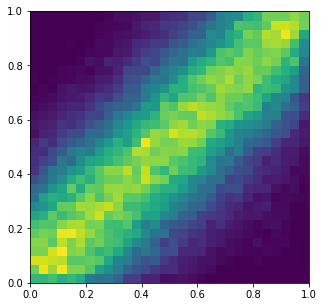

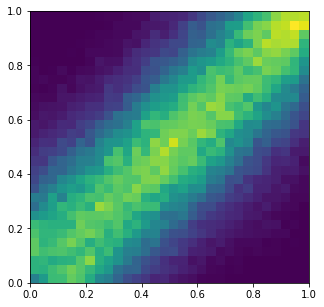

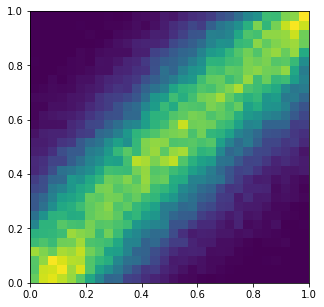

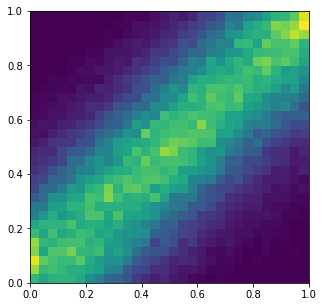

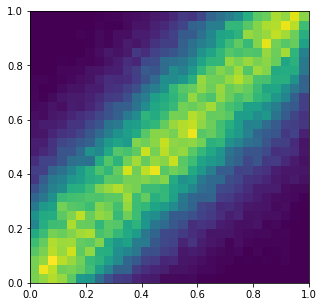

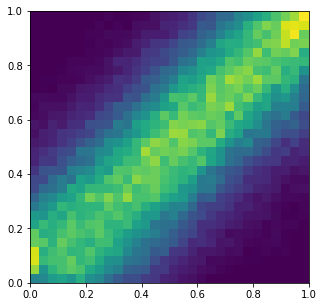

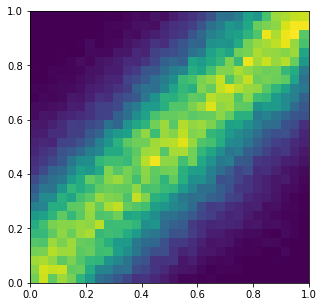

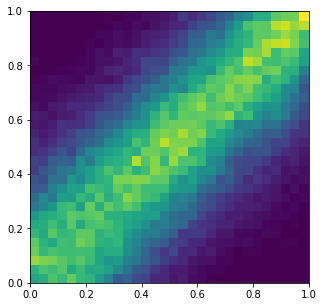

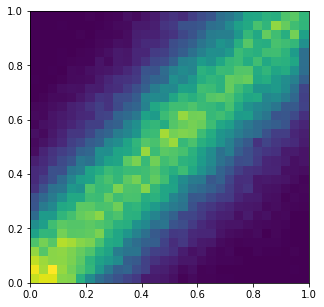

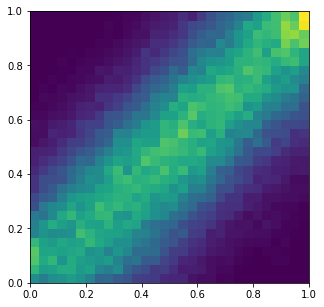

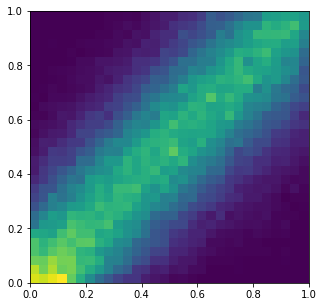

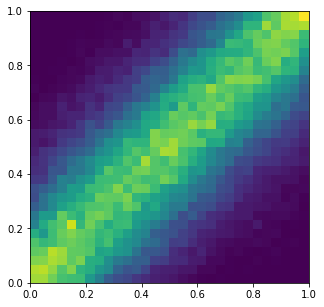

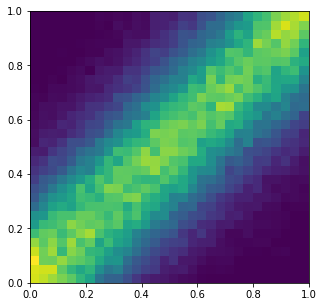

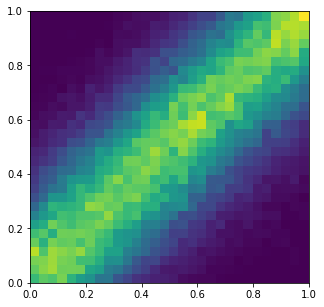

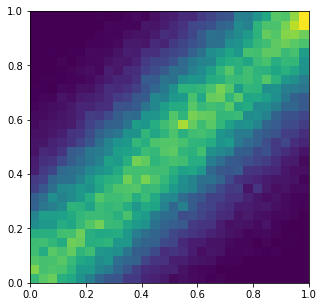

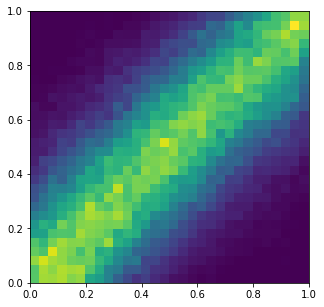

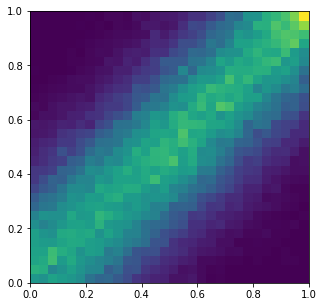

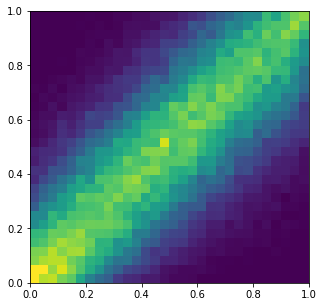

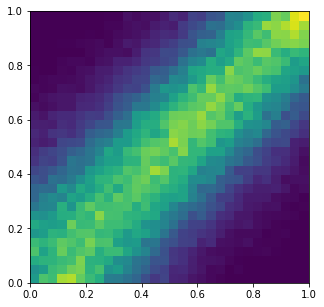

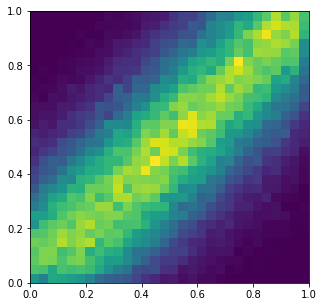

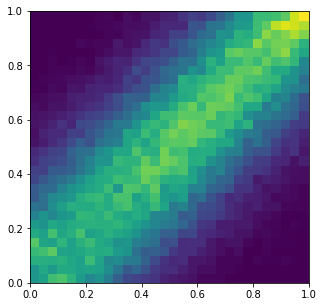

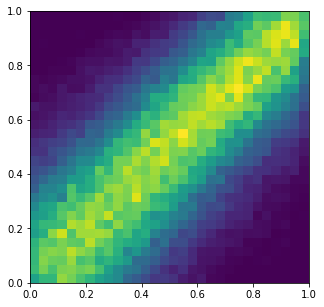

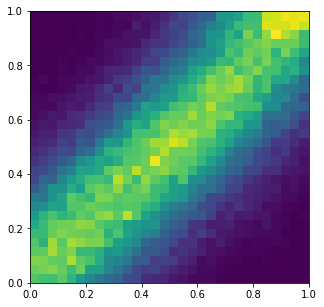

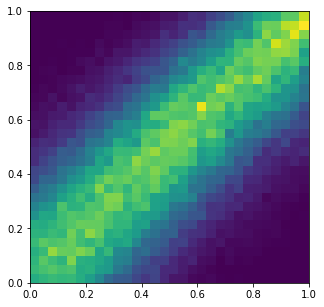

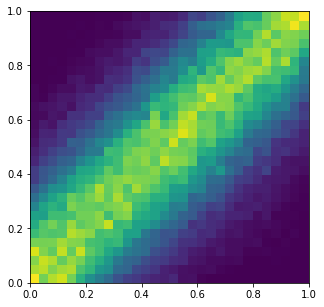

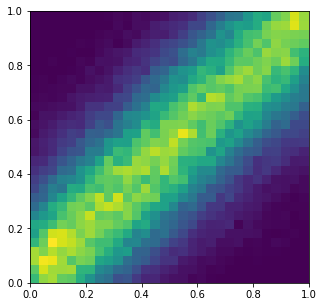

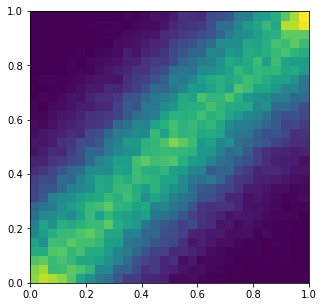

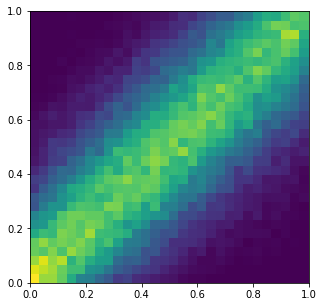

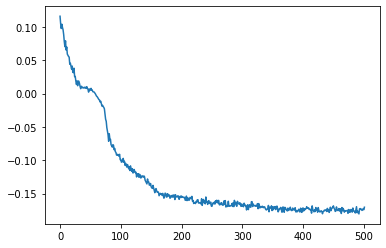

In [13]:
n=5

for k in range(100):
    points = torch.zeros(npoints,3).to(device).uniform_()
    points[:,-1]=0.
    fs = f(points)

    if k%1 == 0:
        for nn in nvps:
            nn.invert()
        nvps.reverse()
        with torch.no_grad():
            xx = sampler(100000)
            for nn in nvps:
                xx=nn(xx)
            xx=sig(xx).cpu().numpy()
            plt.figure(figsize=(5,5))
            plt.hist2d(xx[:,0],xx[:,1],range=((0,1),(0,1)),bins=30)
            plt.show()
        for nn in nvps:
            nn.invert()
        nvps.reverse()
    
    for i in range(n):
        optim.zero_grad()
        xj = asig(points[i*(npoints//n):(i+1)*(npoints//n)])
        for nn in nvps:
            xj = nn(xj)
        x = xj[:,:2]
        j = xj[:,-1]+torch.sum(sampler.prior.log_prob(x),axis=-1)
        L=torch.mean(-j*fs[i*(npoints//n):(i+1)*(npoints//n)])
        L.backward()
        optim.step()
        Ls.append(L.cpu().detach())

plt.plot(Ls)
plt.show()

In [ ]:
xy = torch.zeros(99,99,3).to(device)
for i in range(99):
    for j in range(99):
        xy[i,j,0] = (i+1)/100.
        xy[i,j,1] = (j+1)/100.
        xy[i,j,2] = 1
        
xy = asig(xy)
with torch.no_grad():
    for nn in nvps:
        xy = nn(xy)

p = xy[...,-1] +torch.sum(sampler.prior.log_prob(xy[...,:-1]),axis=-1)

In [ ]:
plt.imshow((torch.exp(p)).cpu().numpy().T,origin="lower")

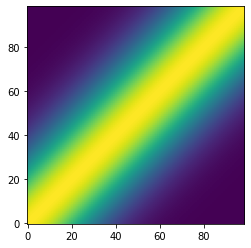

In [11]:
xy = torch.zeros(99,99).to(device)
for i in range(99):
    for j in range(99):
        xy[i,j] = f(torch.tensor([[(i+1)/100.,(j+1)/100.]]))

plt.imshow(xy.cpu().numpy().T,origin="lower")